In [57]:
# Importing libraries

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
from torchsummary import summary

In [2]:
# Pre-processing

# Resize to same dimensions and transfrom uniformly
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, interpolation=False, fill=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Use ImageFolder for our images and labels?

C:\Users\Fisica1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\transforms\transforms.py:1428: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset): 
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        print(self.img_labels)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels) 

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path+'.png').convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

training_data = CustomImageDataset(annotations_file='../dataset/train_csv.csv', img_dir='../dataset/images/', transform=transform)
validation_data = CustomImageDataset(annotations_file='../dataset/test_csv.csv', img_dir='../dataset/images/', transform=transform)

     road706    speedlimit
0    road538    speedlimit
1    road510    speedlimit
2    road504    speedlimit
3    road458    speedlimit
4    road464  trafficlight
..       ...           ...
607  road247    speedlimit
608  road253    speedlimit
609  road535    speedlimit
610  road284    speedlimit
611  road723    speedlimit

[612 rows x 2 columns]
     road712    speedlimit
0    road289  trafficlight
1    road276    speedlimit
2    road262    speedlimit
3    road841     crosswalk
4    road699    speedlimit
..       ...           ...
258  road858    speedlimit
259  road455    speedlimit
260  road509    speedlimit
261  road290    speedlimit
262  road737    speedlimit

[263 rows x 2 columns]


In [6]:
# divide dataset into train-val-test subsets
indices = list(range(len(validation_data)))
np.random.shuffle(indices, )

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(f'Training size: {len(training_data)}\nValidation size: {len(val_idx)} \nTest size: {len(test_idx)}')

Training size: 612
Validation size: 211 
Test size: 52


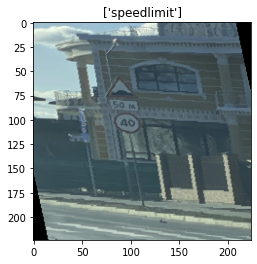

In [49]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(training_data))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[classes])

In [54]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cpu device


In [59]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [60]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [61]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [56]:
# load model from torchvision (with pretrained=True)
vgg = models.vgg16(pretrained=True)
print(vgg)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg.classifier[6] = nn.Linear(4096, 4)

vgg.to(device)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)

NameError: name 'train' is not defined